# Competitive Specializing Network

## Intro

* **Date**: 11/24/2020
* **What**: This is a unsupervised ANN that uses a variant on competitive winner-takes-all (wta) learning to learn a diverse set of data features.  The difference between this network and a standard wta network is that the winner isn't chosen simply as the feature that most closely corresponds to the current input.  Rather, the value that is used in competition takes into account the feature's win-rate and specialization in addition to it's proximity to the current input.  These other two factors are taken into consideration to prevent several neurons from dominating all inputs, and to allow neurons to dominate only the in which they most specialize.  
* **Why**: After the cataclysmic failure that was [the last](../11_24_2020_experiment_faux_snn) experiment, and after reading [this paper](https://www.pnas.org/content/116/16/7723), I realized wta could be the way to go, but it needs some tweaking.  I specifically want to make it harder for the neurons that win everything to keep on winning, to prevent only a couple neurons from dominating all the inputs.  I also noticed that when I ran the code from the above paper, many of the weight-prototype features are learned after a single pass through the data.  However, a couple of the neurons clearly barely or never won inputs, and therefore were never updated.  Thus it took a long time before the neurons settled into their particular feature prototypes, and some never made it past the random initialization phase.  I've designed this current architecture so that the neurons that haven't won in a long time have the best chance at winning.  I've also designed this algorithm so that even with high win rates, inputs that trigger highly specialized features probably cause those features to win.  Essentially, this network is set up to quickly learn a bunch of features, prevent "consistent loser" neurons, and allow neurons to specialize on particular features.
* **Hopes**: Frankly, I really just hope that this network doesn't drastically fail.  It seems like my networks have a habit of doing that.  To be specific, I really *really* want to see the network learn diverse features.  I DON'T WANT TO SEE A SINGLE F@#%ING FUZZY THREE.  DEATH TO FUZZY THREES.  If you don't know what I'm talking about, mozy on over to some of my past experiments.  You'll see plenty of them.  Now, let me be less negative.  What I hope to see is a network that's able to quickly learn a diverse set of features, and then iteratively improve its diversity and quality of features over time.  I don't want to see a bunch of uninitialized values that haven't won because they're being dominated by a select few neurons.  Yeah.  I just want to see a diverse set of specialized features.  Oh, by the way, John Hopfield got back to my email, so I guess I'm in touch with a celebrity 😊
* **Limitations**: \**Sits back and lights a cigar*\* ...well, after my days in the war, I've learned limitations lurk 'round every corner.  You think you've designed the algorithm that's gonna $\Delta$ the world, and ***BAM***, you get hit right in the face with an army of fuzzy threes.  My main concern is that there's too much going on with this current algorithm.  I built in a lot of bells and whistles, and it might not be a bad idea to strip it down a lil bit and see what works and what doesn't.  Anyway, even though I feel like there's not a single fracking way this network could possibly not sufficiently promote specialization in a manner that gives rise to diverse learned features, I've been around the block enough times to know that fuzzy threes are everywhere.  Anyway, to be less dramatic, a limitation of this network is that *if* things do work out, there's enough going on that I won't really know what's working and what's not.  But I can take things apart later in this experiment or in a future experiment, and I want to get the various bells and whistles written down.  Gosh, I hope this works.

## Technicals
Ok, they're are a couple things going on in this architecture.  Let's start with feature specialization.

The feature specialization $s_p$ of a neuron in this network is a measure of how specialized the neuron's feature prototype is to input data.  A higher value of $s_p$ means that the neuron typically wins inputs that are within a very narrow, "specialized" range.  A smaller value of $s_p$ means that the neuron wins inputs from a broader range of inputs, and is therefore "less" specialized.   

From a technical perspective, $s$ is an exponentially moving average (ema) of the neuron's output, *which is only updated when the neuron wins*.  A neuron's output is higher when its feature prototype is closer to the input, so I'll let you use you're lil noggerino to figure out why this sort of ema gives rise to the behavior described in the last paragraph.  So, let $\phi$ be the ema constant, and $o_i$ be the output of the neuron on the $i^{th}$ iteration.  Then we have:

$$
s_{i + 1} = \phi \cdot o_i + (1 - \phi) \cdot s_i
$$

Next up, we have the neuron's win rate $w$.  This shouldn't be considered its absolute win rate, so to speak, because it's a modified ema, but it gives a general metric for how frequently the neuron's winning.  (Higher win-rate means the neuron is winning more often).  The win rate is calculated because neurons with a lower win rate are more likely to win.  This is in place to prevent a small number of neurons from consistently winning inputs.  Now then, I'll first write out the equations governing the evolution of win rate, and then explain why they have this form.  Let $\theta$ be the base win rate ema constant, and let $\delta_{win}$ be a function that equals $1$ if the neuron won the current input, and $0$ otherwise.  Then we have:

$$
\alpha = (1 - s_i) \cdot \theta
$$
$$
w_{i + 1} = \delta_{win} \cdot \alpha + (1 - \alpha) \cdot w_i
$$

So we essentially have a standard ema, but the ema constant is scaled by $1 - s_i$.  This is in place because we can't expect the input dataset to always be a perfectly mixed set of all the different type of data.  Put in other language, we don't want a highly specialized feature to easily change just because it hasn't won in a while.  In general, you want a highly specialized neuron to only shift its prototype if it hasn't won in a *really long time*.  Thus if a neuron is highly specialized, we make the ema constant low to "average" the win rate over a much longer time frame.  Only if it's ema drops over that longer time frame will it start being more volatile.  

Also, as a side note, while I've written this, I've realized it might make more sense to replace $s_i$ with $w_i$ in the above equation.  Think of each win sequence as a block.  Presumably with real-time data, certain neurons tend to win for a block of time during which there isn't a change in the surroundings.  Anyway, that thought probably should be put away for the time being.  

Now, let's talk how the neuron's output is calculated.  Let $\vec{w}$ be the neuron's synapse vector, and $\vec{v}$ be the input vector.  Finally, let $o$ be the neuron's output. Then we have:

$$
o = \frac{\left<\vec{w}, \vec{v}\right>}{|\vec{w}|  |\vec{v}|}
$$

That's right, we're doing spherical learning.  So basically the output is the cosine between the weight and input vector.  Thus to make language a bit more mathematically precise, a highly specialized neuron is a neuron that only tends to win on neurons in within the span of a small solid angle.

This next expression is the term with which the neurons compete.  I'll just write it out and then explain what it's doing.  Let $c$ be the neuron's competing term.  Then (in terms of other variable already defined), we have:

$$
c = \frac{1 - s}{1 - o}\cdot (1 - w)
$$

The neuron with the largest value of $c$ wins the input and has its synapses updated.  I'll describe each term piece by piece.  The term in the denominator is the easiest to understand.  Because $-1 < o < 1$, the larger $o$ is, the larger $c$ is.  Just by itself, due to its monotonic nature, this term would yield the same competitive behavior as if $c = o$.  However, the first term in numerator creates the specializing behavior of the architecture.  If $w$ and $o$ were equal between two neurons, the neuron with the smaller specialization would win the input.  This would make sense given how I've described "specialization" in this context.  However, if you moved the input a bit closer to the more specialized neuron, the denominator term would tend to blow up.  Thus more specialized neurons have a higher chance of winning inputs within their realm of specialization due to the interplay between the numerator and denominator of the above expression.  

All the terms described so far are finally multiplied by (1 - w).  This term exists to ensure against the "consistent loser" phenomenon seen in wta networks.  If several neurons are consistently winning inputs, they'll have higher values of $w$.  Furthermore, consistent losers will have low values of $w$.  Thus this term makes it so that loser neurons have a better chance of winning.  And, as is typically seen in wta networks, once an input starts moving toward an actual input vector, there tends to be a bit of a "snowball" effect that causes that neuron to win more and more inputs until it's learned a reasonable specialized feature prototype.  

Finally, once a neuron's won, let's talk about how the neuron's synapses are updated.  Let $\xi$ be the base learning constant of the network.  Then in terms of other variables previously discussed, we have:

$$
\Delta w_i = \left( v_i - \left<w, v\right> w_i \right)\cdot(1 - s)\cdot\xi
$$

This learning rule is essentially what you'd expect, aside from two notable additions.  First, $w_i$ is multiplied by $\left<w, v\right>$ to cause $\vec{w}$ to eventually tend toward a vector on the unit sphere.  This additional constraint is inspired by [this paper](https://www.pnas.org/content/116/16/7723), and prevents magnitude changes in $\vec{w}$ that wouldn't result in any useful paper given the expression for $o$.

Finally, the learning constant is multiplied by $(1 - s)$.  This allows us to choose a fairly large $\xi$, and as the neuron becomes more specialized, the learning constant becomes more fine-tuned to provide only small adjustments to the already specialized prototype.  Note that it might be useful to raise the $(1 - s)$ term a power greater than 1.  The raised power would magnify this "fine-tuning" effect.  However, there's no reason to explore this before it's clear whether this architecture leads to any useful results.

## Code

In [122]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, 1, L])

In [145]:
# Weight plotter visciously stolen from bio network paper
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=0,vmax=nc)
#     fig.colorbar(im,ticks=[0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()

In [148]:
# mu and sigma are for weight initialization
# Kx is the number of columns of neurons
# Ky is the number of rows of neurons
# Nep is the number of epochs
# T_s is the number of training images
# xi is the base learning constant
# theta is the base ema constant for win rate
# phi is the ema constant for specialization

def run_experiment(mu, sigma, Kx, Ky, Nep, T_s, xi, theta, phi):
    N = Kx * Ky
    
    w = np.random.normal(mu, sigma, (N, L)) # synapses of each neuron
    s = np.zeros(N) # Specialization for each neuron
    r = np.zeros(N) # Win rate for each neuron
    
    for ep in range(Nep):
        # Uncomment the following line if you'd like to shuffle the data between epochs
        #flat_x = flat_x[np.random.permutation(S), :]
        
        for i in tqdm(range(T_s)):
            # Calculate neuron outputs
            v = flat_x[i, :]
            w_mul_v = w @ v.T
            
            o = w_mul_v / (np.array([np.linalg.norm(v) * np.linalg.norm(w, axis=1)])).T
            c = (1 - s) * (1 - r) / (1 - o).T[0]
            
#             print(w_mul_v)
#             print(o)
#             print(c)
            
            # Find winner
            win_i = np.argmax(c)
#             print(win_i)
            
#             print(w[win_i])
#             print(w_mul_v[win_i])
#             print(s[win_i])
            
            # Update winner synapses
#             print(v - (w_mul_v[win_i] * w[win_i]).shape)
#             print((1 - s[win_i]) * xi)
#             print(((v - (w_mul_v[win_i] * w[win_i])) * (1 - s[win_i]) * xi).shape)
#             print(w[win_i])
            w[win_i] += ((v - (w_mul_v[win_i] * w[win_i])) * (1 - s[win_i]) * xi)[0]
            
            # Update win rates
            alpha = (1 - s) * theta
            r *= (1 - alpha)
            r[win_i] += alpha[win_i]
            
            # Update winner specialization
            s[win_i] *= (1 - phi)
            s[win_i] += phi * o[win_i]
            
        print(w)
            
        draw_weights(np.nan_to_num(w), Kx, Ky)

100%|██████████| 10000/10000 [00:02<00:00, 4020.13it/s]


[[ 0.00509704 -0.01172276  0.01221912 ... -0.00379871  0.00077756
  -0.00041949]
 [-0.00840087  0.0093662  -0.01677756 ... -0.00144353  0.00063658
  -0.00132893]
 [-0.00935884 -0.00713817  0.00453781 ... -0.00602296 -0.01078878
   0.00450723]
 ...
 [-0.00364512  0.00276928 -0.00225341 ...  0.00860461  0.00379777
   0.00557473]
 [-0.0036755   0.00186041 -0.00402122 ...  0.00413762 -0.00027942
  -0.00707819]
 [-0.00806883 -0.01508647  0.01291118 ... -0.00426326  0.0029282
  -0.01445686]]


ValueError: cannot convert float NaN to integer

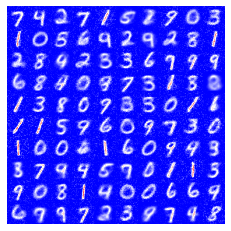

In [167]:
mu = 0
sig = 1
Kx = 10
Ky = 10
Nep = 2
T_s = 10000
xi = 0.01
theta = 2 / 17
phi = 2 / 11

run_experiment(mu, sig, Kx, Ky, Nep, T_s, xi, theta, phi)

In [26]:
np.zeros((3))

array([0., 0., 0.])

In [4]:
a = np.array([[1, 2], [3, 4], [5, 6], [8, 9]])

In [18]:
a[1] += [2, 1]

In [19]:
a


array([[1, 2],
       [8, 4],
       [5, 6],
       [8, 9]])

In [23]:
np.argsort(a, axis=0)

array([[0, 0],
       [2, 1],
       [1, 2],
       [3, 3]], dtype=int64)

In [30]:
np.linalg.norm(a, axis=1)

array([ 2.23606798,  8.94427191,  7.81024968, 12.04159458])

In [31]:
b = np.random.uniform(0, 1, (10, 5))

In [32]:
b

array([[0.70998101, 0.97218933, 0.33291869, 0.12563595, 0.54536763],
       [0.11909374, 0.96141049, 0.52203509, 0.76312738, 0.42297847],
       [0.08625774, 0.37549581, 0.02239295, 0.53532444, 0.62693226],
       [0.70209058, 0.76606746, 0.75856718, 0.7266226 , 0.40523973],
       [0.82423755, 0.2219953 , 0.91807014, 0.22188119, 0.6828966 ],
       [0.95151937, 0.07295871, 0.65454507, 0.52684785, 0.37063101],
       [0.97529092, 0.27358562, 0.68713009, 0.19013733, 0.42750177],
       [0.25146857, 0.82285609, 0.21170672, 0.09637429, 0.53642932],
       [0.44942251, 0.67100037, 0.73704339, 0.32169271, 0.34610176],
       [0.11764807, 0.25441877, 0.95087224, 0.68080322, 0.55712974]])

In [34]:
c = np.linalg.norm(b, axis=1)
c

array([1.36867463, 1.40438181, 0.9102501 , 1.53212739, 1.44467341,
       1.32441585, 1.31038132, 1.04028493, 1.19110356, 1.32537336])

In [35]:
np.argmax(c)

3